In [ ]:
import os
import shutil
import ast
import itertools
from collections import Counter

import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

from pcwcf.common.policies import ConstrainedActorCriticPolicy
from gym_pcwcf.config.config_cicids2017_webattacks import FEATURES

In [3]:
arr = np.load('results_real.npy')
arr_val = np.load('results_val.npy')
arr_test = np.load('results_test.npy')

In [22]:
np.set_printoptions(precision=3)

In [5]:
#индексы триалов с лучшими показателями validation reward
lambdas_count = 7
best_count = 1
lambdas = np.concatenate([np.repeat(lmbd, 5) for lmbd in [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001] ])
seeds_count = len(lambdas) // lambdas_count
a = arr_val[:,0].reshape(lambdas_count,seeds_count) #validation reward, reshaped
best_idx =a.argsort()[np.arange(lambdas_count),-best_count:] + np.array([seeds_count*i for i in range(lambdas_count)])[:,None]
best_idx = best_idx.flatten()
best_idx

array([ 2,  5, 13, 15, 20, 27, 33])

In [30]:
eval_log_dir = "/tmp/gym/val/"
def create_dir(dirname):
    # Create log dir     
    try:
        shutil.rmtree(eval_log_dir)
    except:
        pass
    finally:
        os.makedirs(eval_log_dir, exist_ok=True)

In [32]:
from sklearn.metrics import precision_score, recall_score
def eval_model(index):
    lambda_coefficient = lambdas[index]
    number = str(index + 1)
    create_dir(eval_log_dir + number +"/")
    env_id = 'gym_pcwcf:cwcf-v0'
    env_kwargs = dict(mode='TEST',
                 is_binary_classification=True,
                 random_mode=False,
                 lambda_coefficient=lambda_coefficient,
                 terminal_reward=[[0, -0.3], 
                                  [-0.7, 0]])
    monitor_kwargs = dict(info_keywords=('y_true', 'y_predict', 'features'))
    eval_env = gym.make(env_id, **env_kwargs)
    eval_env = Monitor(eval_env, filename=eval_log_dir, **monitor_kwargs)
    model_dir = '/home/student/projects/site-packages/rl-baselines3-zoo/logs/11_01_2022/ppo/cwcf-v0_' +  number +'/best_model.zip'
    model = PPO.load(model_dir)
    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=len(eval_env.data_y))
    df = load_results(eval_log_dir)
    return df

In [33]:
#full statistics
detailed_results = [eval_model(x) for x in (best_idx + 1)]

In [38]:
lambda_values = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

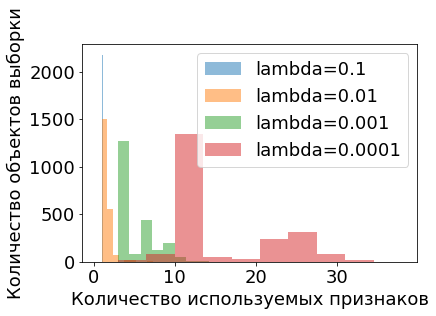

In [61]:
idx = 2
for idx in (0, 2,4, 6):
    df = detailed_results[idx]
    lambda_value = lambda_values[idx] 
    plt.hist(df.l.map(lambda x: x-1), bins=10, alpha=0.5, label='lambda=' + str(lambda_value))
plt.legend(loc='upper right')
plt.xlabel('Количество используемых признаков')
plt.ylabel('Количество объектов выборки')
plt.rcParams.update({'font.size': 18})
plt.show()

In [ ]:
#copied from approb_model_real_data.ipynb
#no need to run another time
detailed_results = np.array([[ 0.80619112,  0.91590214,  0.8575519 ,  1.        ],
       [ 0.86029412,  0.89449541,  0.87706147,  1.        ],
       [ 0.95309883,  0.87003058,  0.90967226,  1.40944521],
       [ 0.95688226,  0.882263  ,  0.91805887,  1.42503439],
       [ 0.95341098,  0.87614679,  0.91314741,  4.87574507],
       [ 0.96166667,  0.882263  ,  0.92025518,  7.05135259],
       [ 0.94909688,  0.88379205,  0.91528108, 15.36680422]])

detailed_results

In [26]:
precisions = detailed_results[:,0]
recalls = detailed_results[:,1]
f1scores = detailed_results[:,2]
used_features = detailed_results[:,3]

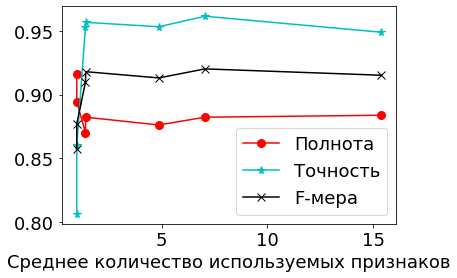

In [28]:
plt.plot(used_features, recalls, marker='o', c='r', markersize=8, label = 'Полнота')
plt.plot(used_features, precisions, marker='*', c='c', markersize=8, label = 'Точность')
plt.plot(used_features, f1scores, marker='x', c='k', markersize=8, label = 'F-мера')
plt.xlabel('Среднее количество используемых признаков')
plt.rcParams.update({'font.size': 18})
plt.legend()
plt.show()

In [32]:
#индексы триалов с лучшими показателями validation reward
lambdas_count = 7
best_count = 1
lambdas = np.concatenate([np.repeat(lmbd, 5) for lmbd in [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001] ])
seeds_count = len(lambdas) // lambdas_count
a = arr_val[:,0].reshape(lambdas_count,seeds_count) #validation reward, reshaped
best_idx =a.argsort()[np.arange(lambdas_count),-best_count:] + np.array([seeds_count*i for i in range(lambdas_count)])[:,None]
best_idx = best_idx.flatten()
best_idx

array([ 2,  5, 13, 15, 20, 27, 33])

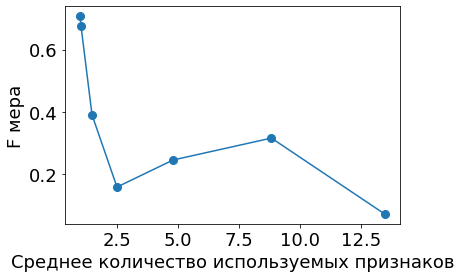

In [33]:
best_arr = arr[best_idx]
plt.plot(best_arr[:,3], best_arr[:,2], marker='o', markersize=8)
plt.xlabel('Среднее количество используемых признаков')
plt.ylabel('F мера')
plt.rcParams.update({'font.size': 18})
plt.show()

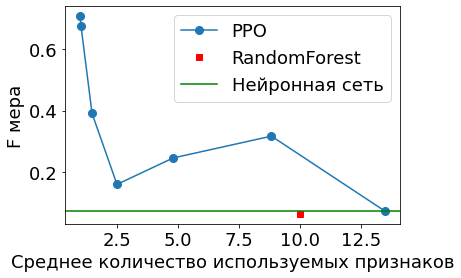

In [17]:
best_arr = arr[best_idx]
plt.plot(best_arr[:,3], best_arr[:,2], marker='o', markersize=8, label='PPO')
plt.xlabel('Среднее количество используемых признаков')
plt.ylabel('F мера')
# plt.plot(10, 0.064, marker='s', markersize=8, label='RandomForest')
plt.plot(10, 0.064,'rs', label='RandomForest') #RandomForestModel_Web_attacks.ipynb
plt.axhline(y=0.075, color='g', linestyle='-', label='Нейронная сеть') #neural_net.ipynb
plt.rcParams.update({'font.size': 18})
plt.legend()
plt.show()

In [34]:
best_arr

array([[-0.276,  0.737,  0.707,  1.   ],
       [-0.242,  0.719,  0.676,  1.033],
       [-0.312,  0.572,  0.391,  1.485],
       [-0.383,  0.439,  0.16 ,  2.505],
       [-0.342,  0.513,  0.246,  4.8  ],
       [-0.324,  0.537,  0.317,  8.818],
       [-0.382,  0.446,  0.074, 13.442]])